In [64]:
import re
import nltk
from nltk.stem.snowball import SnowballStemmer
from nltk import wordnet, pos_tag
from nltk import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn import metrics
from nltk.corpus import wordnet
import string
from nltk import pos_tag
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [65]:
import pandas as pd
import numpy as np

In [66]:
url_test = 'https://raw.githubusercontent.com/kryzhikov/Sample-ML-Repo/main/11.%20Texts/nlp/test.csv'
url_train = 'https://raw.githubusercontent.com/kryzhikov/Sample-ML-Repo/main/11.%20Texts/nlp/train.csv'
url_positive_words = 'https://raw.githubusercontent.com/kryzhikov/Sample-ML-Repo/main/11.%20Texts/nlp/positive-words.txt'
url_negative_words = 'https://raw.githubusercontent.com/kryzhikov/Sample-ML-Repo/main/11.%20Texts/nlp/negative-words.txt'
url_sentiworldnet = 'https://raw.githubusercontent.com/kryzhikov/Sample-ML-Repo/main/11.%20Texts/nlp/SentiWordNet.txt'
url_sample_submission = 'https://raw.githubusercontent.com/kryzhikov/Sample-ML-Repo/main/11.%20Texts/nlp/sample%20submission.csv'

In [67]:
test = pd.read_csv(url_test, encoding = 'unicode_escape')
train = pd.read_csv(url_train, encoding = 'unicode_escape')
#test_real = pd.read_csv(url_sample_submission, encoding = 'unicode_escape')

In [68]:
train

,Id,Hotel_name,Review_Title,Review_Text,Rating
0,0,Park Hyatt,Refuge in Chennai,Excellent room and exercise facility. All arou...,80.0
1,1,Hilton Chennai,Hilton Chennai,Very comfortable and felt safe. \r\nStaff were...,100.0
2,2,The Royal Regency,No worth the rating shown in websites. Pricing...,Not worth the rating shown. Service is not goo...,71.0
3,3,Rivera,Good stay,"First of all nice & courteous staff, only one ...",86.0
4,4,Park Hyatt,Needs improvement,Overall ambience of the hotel is very good. In...,86.0
...,...,...,...,...,...
2346,2346,Hyatt Regency Chennai,NaN,Most impressive service by staff in all areas....,80.0
2347,2347,New Woodlands,Homely villa,New woodlands chennai which gave me a homely e...,71.0
2348,2348,Samudra Residency,Nice accommodation and facilities,Awesome I liked the neatness and maintenance. ...,100.0
2349,2349,The Residency Chennai,The Residency Good Centrally located Hotel,The overall experience was good. However the w...,80.0


In [69]:
train.shape

(2351, 5)

In [70]:
train.isnull().sum()

Id                0
Hotel_name        0
Review_Title    215
Review_Text       0
Rating            0
dtype: int64

In [71]:
train.isna().sum()

Id                0
Hotel_name        0
Review_Title    215
Review_Text       0
Rating            0
dtype: int64

Видим, что nan есть только в названиях отзывов.

Посмотрим на гистограмму распределения оценок:

In [72]:
import plotly.express as px
fig = px.histogram(train, x="Rating")
fig.show()

In [73]:
train['Rating'].value_counts()

86.0     465
100.0    441
71.0     327
80.0     307
60.0     172
65.0     163
57.0     144
40.0      88
20.0      88
43.0      87
29.0      69
Name: Rating, dtype: int64

Очень забавное, дискретное распределение оценок - ощущение, что такие отзывы были выбраны специально.

Перед тем, как заняться преобразованием текста, имеет смысл добавить новые признаки - кажется, что длина отзыва и медианная оценка конкретного отеля будут полезными признаками.

In [74]:
import matplotlib.pyplot as plt


In [75]:
len_review_column = train.apply(lambda x: len(x['Review_Text']), axis=1)

(array([136., 239., 215., 174., 395., 437., 350., 191., 126.,  88.]),
 array([  1. ,  45.8,  90.6, 135.4, 180.2, 225. , 269.8, 314.6, 359.4,
        404.2, 449. ]),
 <a list of 10 Patch objects>)

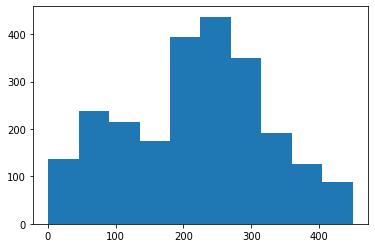

In [76]:
plt.hist(len_review_column)

In [78]:
median_rating = train.apply(lambda x: train['Rating'][train['Hotel_name'] == x['Hotel_name']].median(), axis=1)

In [79]:
median_rating

0        86.0
1        86.0
2        71.0
3        86.0
4        86.0
        ...  
2346    100.0
2347     71.0
2348     71.0
2349     80.0
2350     64.0
Length: 2351, dtype: float64

Приступаем к обработке текста.

Приведем все к одному регистру, засплитим, удалим пунктуацию, удалим часто используемые слова, навесим POS теги и, соответственно, проведем лемматизацию.

In [80]:
def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def clean_text(text):
    text = text.lower()
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    text = [word for word in text if not any(c.isdigit() for c in word)]
    stop = stopwords.words('english')
    text = [x for x in text if x not in stop]
    text = [t for t in text if len(t) > 0]
    pos_tags = pos_tag(text)
    text = [WordNetLemmatizer().lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags]
    text = [t for t in text if len(t) > 1]
    text = " ".join(text)
    return(text)


train["review_clean"] = train["Review_Text"].apply(lambda x: clean_text(x))

In [81]:
train

,Id,Hotel_name,Review_Title,Review_Text,Rating,review_clean
0,0,Park Hyatt,Refuge in Chennai,Excellent room and exercise facility. All arou...,80.0,excellent room exercise facility around atmosp...
1,1,Hilton Chennai,Hilton Chennai,Very comfortable and felt safe. \r\nStaff were...,100.0,comfortable felt safe \r\nstaff helpful respec...
2,2,The Royal Regency,No worth the rating shown in websites. Pricing...,Not worth the rating shown. Service is not goo...,71.0,worth rating show service good room well maint...
3,3,Rivera,Good stay,"First of all nice & courteous staff, only one ...",86.0,first nice courteous staff one con stay time c...
4,4,Park Hyatt,Needs improvement,Overall ambience of the hotel is very good. In...,86.0,overall ambience hotel good room facility need...
...,...,...,...,...,...,...
2346,2346,Hyatt Regency Chennai,NaN,Most impressive service by staff in all areas....,80.0,impressive service staff area good restaurant ...
2347,2347,New Woodlands,Homely villa,New woodlands chennai which gave me a homely e...,71.0,new woodland chennai give homely experience lu...
2348,2348,Samudra Residency,Nice accommodation and facilities,Awesome I liked the neatness and maintenance. ...,100.0,awesome like neatness maintenance facility rea...
2349,2349,The Residency Chennai,The Residency Good Centrally located Hotel,The overall experience was good. However the w...,80.0,overall experience good however wi-fi get disc...


Так как возможных значений рейтинга всего 10, test части, откуда могут появиться новые значения рейтинга у нас нет, то буду рассматривать задачу как задачу классификации(в любом случае, она быстро переделывается в задачу регрессии).

In [82]:
train['Rating'] = train.apply(lambda x : int(x['Rating']), axis=1)

In [83]:
train

,Id,Hotel_name,Review_Title,Review_Text,Rating,review_clean
0,0,Park Hyatt,Refuge in Chennai,Excellent room and exercise facility. All arou...,80,excellent room exercise facility around atmosp...
1,1,Hilton Chennai,Hilton Chennai,Very comfortable and felt safe. \r\nStaff were...,100,comfortable felt safe \r\nstaff helpful respec...
2,2,The Royal Regency,No worth the rating shown in websites. Pricing...,Not worth the rating shown. Service is not goo...,71,worth rating show service good room well maint...
3,3,Rivera,Good stay,"First of all nice & courteous staff, only one ...",86,first nice courteous staff one con stay time c...
4,4,Park Hyatt,Needs improvement,Overall ambience of the hotel is very good. In...,86,overall ambience hotel good room facility need...
...,...,...,...,...,...,...
2346,2346,Hyatt Regency Chennai,NaN,Most impressive service by staff in all areas....,80,impressive service staff area good restaurant ...
2347,2347,New Woodlands,Homely villa,New woodlands chennai which gave me a homely e...,71,new woodland chennai give homely experience lu...
2348,2348,Samudra Residency,Nice accommodation and facilities,Awesome I liked the neatness and maintenance. ...,100,awesome like neatness maintenance facility rea...
2349,2349,The Residency Chennai,The Residency Good Centrally located Hotel,The overall experience was good. However the w...,80,overall experience good however wi-fi get disc...


Добавим признаки, которые создали сами:

In [84]:
train['len_review'] = len_review_column
train['median_rating'] = median_rating

In [85]:
train

,Id,Hotel_name,Review_Title,Review_Text,Rating,review_clean,len_review,median_rating
0,0,Park Hyatt,Refuge in Chennai,Excellent room and exercise facility. All arou...,80,excellent room exercise facility around atmosp...,207,86.0
1,1,Hilton Chennai,Hilton Chennai,Very comfortable and felt safe. \r\nStaff were...,100,comfortable felt safe \r\nstaff helpful respec...,171,86.0
2,2,The Royal Regency,No worth the rating shown in websites. Pricing...,Not worth the rating shown. Service is not goo...,71,worth rating show service good room well maint...,254,71.0
3,3,Rivera,Good stay,"First of all nice & courteous staff, only one ...",86,first nice courteous staff one con stay time c...,225,86.0
4,4,Park Hyatt,Needs improvement,Overall ambience of the hotel is very good. In...,86,overall ambience hotel good room facility need...,250,86.0
...,...,...,...,...,...,...,...,...
2346,2346,Hyatt Regency Chennai,NaN,Most impressive service by staff in all areas....,80,impressive service staff area good restaurant ...,354,100.0
2347,2347,New Woodlands,Homely villa,New woodlands chennai which gave me a homely e...,71,new woodland chennai give homely experience lu...,381,71.0
2348,2348,Samudra Residency,Nice accommodation and facilities,Awesome I liked the neatness and maintenance. ...,100,awesome like neatness maintenance facility rea...,212,71.0
2349,2349,The Residency Chennai,The Residency Good Centrally located Hotel,The overall experience was good. However the w...,80,overall experience good however wi-fi get disc...,116,80.0


Создадим test и train части:

In [86]:
X_train, X_test, y_train, y_test = train_test_split(train[['review_clean', 'Rating', 'len_review', 'median_rating']], train['Rating'], test_size= 1/4, random_state=42)

In [87]:
X_train

,review_clean,Rating,len_review,median_rating
1547,arrive late night thailand look forward drink ...,80,302,80.0
1917,notice many change hotel check process smooth ...,86,352,86.0
543,many mosquito late check warm room fridge work...,20,449,65.0
1535,stay hotel comfortable transport easily available,60,60,60.0
494,stay good overall stay three day location good...,86,269,57.0
...,...,...,...,...
1638,room look like old small poorly maintain found...,71,309,71.0
1095,great experience really good hotel professiona...,100,153,100.0
1130,hotel locate within km chennai central station...,57,241,71.0
1294,room old poor value money food start minimum p...,29,254,65.0


Для начала воспользуемся двумя подходами - bag of words и TF-IDF.

In [88]:
cv=CountVectorizer(min_df=0,max_df=1,binary=False,ngram_range=(1,2))
X_train_cv=cv.fit_transform(X_train['review_clean'])
X_test_cv=cv.transform(X_test['review_clean'])

print('BOW_cv_train:',X_train_cv.shape)
print('BOW_cv_test:',X_test_cv.shape)

BOW_cv_train: (1763, 14782)
BOW_cv_test: (588, 14782)


In [89]:
tv=TfidfVectorizer(min_df=0,max_df=1,use_idf=True, ngram_range=(1,2))
X_train_tv=tv.fit_transform(X_train['review_clean'])
X_test_tv=tv.transform(X_test['review_clean'])

print('Tfidf_train:',X_train_tv.shape)
print('Tfidf_test:',X_test_tv.shape)

Tfidf_train: (1763, 14782)
Tfidf_test: (588, 14782)


В качестве классификатора возьмем RandomForest, логистическую регрессию, knn, decision tree.

In [90]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

Random forest:

CV:

In [91]:
classifier_cv = RandomForestClassifier(n_estimators=1000, random_state=0)
classifier_cv.fit(X_train_cv, y_train) 

RandomForestClassifier(n_estimators=1000, random_state=0)

In [92]:
preds_cv = classifier_cv.predict(X_test_cv)
print(classifier_cv.score(X_train_cv, y_train))
print(classifier_cv.score(X_test_cv, y_test))

0.761769710720363
0.32653061224489793


TF-IDF:

In [95]:
classifier_tv = RandomForestClassifier(n_estimators=1000, random_state=0)
classifier_tv.fit(X_train_tv, y_train) 

RandomForestClassifier(n_estimators=1000, random_state=0)

In [96]:
preds_tv = classifier_tv.predict(X_test_tv)
print(classifier_tv.score(X_train_tv, y_train))
print(classifier_tv.score(X_test_tv, y_test))

0.761769710720363
0.32653061224489793


Логистическая регрессия:

CV:

In [98]:
lr_cv = LogisticRegression()
lr_cv.fit(X_train_cv, y_train)

LogisticRegression()

In [99]:
preds_lg_cv = lr_cv.predict(X_test_cv)
print(lr_cv.score(X_train_cv, y_train))
print(lr_cv.score(X_test_cv, y_test))

0.7470221213840046
0.3299319727891156


TF-IDF:

In [101]:
lr_tv = LogisticRegression()
lr_tv.fit(X_train_tv, y_train)

LogisticRegression()

In [102]:
preds_lg_tv = lr_tv.predict(X_test_tv)
print(lr_tv.score(X_train_tv, y_train))
print(lr_tv.score(X_test_tv, y_test))

0.5053885422575156
0.3112244897959184


KNN:

CV:

In [103]:
knn_cv = KNeighborsClassifier()
knn_cv.fit(X_train_cv, y_train)

KNeighborsClassifier()

In [104]:
preds_knn_cv = knn_cv.predict(X_test_cv)
print(knn_cv.score(X_train_cv, y_train))
print(knn_cv.score(X_test_cv, y_test))

0.3828701077708451
0.19727891156462585


TF-IDF:

In [105]:
knn_tv = KNeighborsClassifier()
knn_tv.fit(X_train_tv, y_train)

KNeighborsClassifier()

In [106]:
preds_knn_tv = knn_tv.predict(X_test_tv)
print(knn_tv.score(X_train_tv, y_train))
print(knn_tv.score(X_test_tv, y_test))

0.290414066931367
0.15476190476190477


Мрак.

Посмотрим на word2vec:


In [111]:
import gensim
import xgboost as xgb


In [114]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-english/crawl-300d-2M.vec.zip -O crawl-300d-2M.vec.zip
!unzip crawl-300d-2M.vec.zip

--2022-05-18 20:54:30--  https://dl.fbaipublicfiles.com/fasttext/vectors-english/crawl-300d-2M.vec.zip
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 172.67.9.4, 104.22.74.142, 104.22.75.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|172.67.9.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1523785255 (1.4G) [application/zip]
Saving to: ‘crawl-300d-2M.vec.zip’

crawl-300d-2M.vec.z 100%[===================>]   1.42G  13.1MB/s    in 38s     

2022-05-18 20:55:09 (38.4 MB/s) - ‘crawl-300d-2M.vec.zip’ saved [1523785255/1523785255]

Archive:  crawl-300d-2M.vec.zip
  inflating: crawl-300d-2M.vec       


In [116]:
model = gensim.models.KeyedVectors.load_word2vec_format('crawl-300d-2M.vec', binary = True, encoding='unicode_escape' ) 
model.vector_size

300